In [43]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame

import os
import sys

In [44]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import WIDTH, HEIGHT
from game import Game

In [45]:
class SpaceShipEnv(gym.Env):
    """
    Gymnasium version of the SpaceShip environment.
    """
    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self, frame_stack: int = 4, render_mode: str = None):
        super().__init__()
        self.frame_stack = frame_stack
        self.render_mode = render_mode

        # 建立遊戲實例
        self.game = Game(frame_stack=frame_stack)

        # 動作空間
        self.action_space = spaces.Discrete(4)

        # 觀測空間 shape=(H, W, 3*frame_stack)
        sample = self.game.stacked_state  # shape=(W, H, C)
        h, w, c = np.transpose(sample, (1,0,2)).shape
        self.observation_space = spaces.Box(
            low=0, high=255,
            shape=(h, w, c),
            dtype=np.uint8
        )

        # 延遲初始化 Pygame 視窗
        self.window = None
        self.clock = pygame.time.Clock()

    def reset(self, *, seed=None, options=None):
        # Gymnasium 正確的 reset signature
        super().reset(seed=seed)
        # 重建遊戲，清空 deque
        self.game = Game(frame_stack=self.frame_stack)

        obs = np.transpose(self.game.stacked_state, (1,0,2))
        info = {}
        return obs, info

    # 在 spaceship_env 或 spaceship_env_gymnasium 裡的 step()
    def step(self, action):
        # 先記下上一步的分數
        prev_score = self.game.score

        # 執行遊戲邏輯
        self.game.update(action)

        # 計算增量 reward
        cur_score = self.game.score
        reward = float(cur_score - prev_score)

        # 觀測、done 邏輯不變
        obs = np.transpose(self.game.stacked_state, (1,0,2))
        terminated = (not self.game.running) or (cur_score >= 10000)
        truncated = False
        info = {}

        if self.render_mode == "human":
            self.render()

        return obs, reward, terminated, truncated, info


    def render(self):
        if self.render_mode != "human":
            return

        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL (Gymnasium)")
        # 繪製當前一幀
        self.game.draw(self.window)
        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.window:
            pygame.quit()
            self.window = None

## DQN model

In [46]:
import random
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque

import matplotlib.pyplot as plt

In [47]:
# 影像前處理
def preprocess_stack(raw: np.ndarray, frame_stack: int) -> torch.Tensor:
    """
    raw: np.ndarray, shape=(W, H, 3*frame_stack), dtype=uint8
    return: torch.Tensor, shape=(frame_stack, H, W), float32 in [0,1]
    """
    W, H, Ctot = raw.shape
    C = Ctot // frame_stack
    # 重塑並轉軸： (W, H, stack, C) → (stack, H, W, C)
    frames = raw.reshape(W, H, frame_stack, C).transpose(2, 1, 0, 3)
    # 轉灰階 + resize
    gray_resized = []
    for f in frames:
        # 1. RGB→灰階
        g = cv2.cvtColor(f, cv2.COLOR_RGB2GRAY)
        # 2. Resize 到 84×84
        g84 = cv2.resize(g, (84, 84), interpolation=cv2.INTER_AREA)
        gray_resized.append(g84)

    stack = np.stack(gray_resized, axis=0)          # (stack, 84, 84)
    tensor = torch.from_numpy(stack).float() / 255.0
    return tensor

In [48]:
# DQN 網路結構 (灰階單通道)
class DQN(nn.Module):
    def __init__(self, action_dim, frame_stack):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(frame_stack, 32, kernel_size=8, stride=4),  # 現在有 4 幀
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [49]:
# 經驗回放
class ReplayBuffer:
    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return (torch.FloatTensor(s),
                torch.LongTensor(a),
                torch.FloatTensor(r),
                torch.FloatTensor(s_),
                torch.FloatTensor(d))

    def __len__(self):
        return len(self.buffer)

In [50]:
# 超參數
EPISODES       = 500
BATCH_SIZE     = 256
GAMMA          = 0.99
EPS_START      = 1.0
EPS_END        = 0.01
EPS_DECAY      = 0.990
LR             = 1e-4
TARGET_UPDATE  = 5
FRAME_STACK    = 4

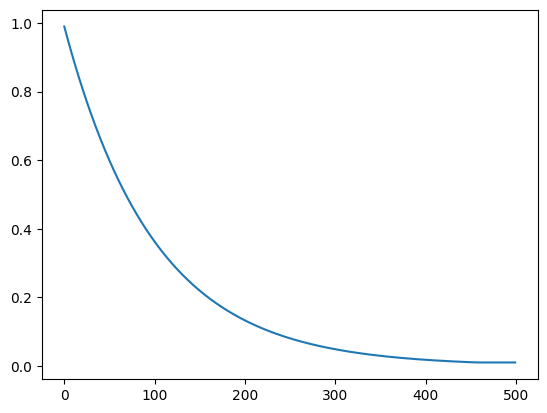

In [51]:
epsilon_list=[]
epsilon=EPS_START
for i in range(500):
    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [52]:
# 初始化
env = SpaceShipEnv(frame_stack=FRAME_STACK, render_mode=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

action_dim = env.action_space.n
policy_net = DQN(action_dim, FRAME_STACK).to(device)
target_net = DQN(action_dim, FRAME_STACK).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
buffer = ReplayBuffer(capacity=10000)


In [53]:
# 主訓練迴圈
epsilon = EPS_START
reward_history = []
best_reward = -float("inf")

for episode in range(1, EPISODES+1):
    # reset → obs, info
    raw, _ = env.reset()
    state = preprocess_stack(raw, FRAME_STACK).to(device)
    total_reward = 0.0
    done = False

    while not done:
        # ε-greedy 取動作
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_vals = policy_net(state.unsqueeze(0))
                action = q_vals.argmax(1).item()

        # step → obs, reward, terminated, truncated, info
        raw_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state = preprocess_stack(raw_next, FRAME_STACK).to(device)
        total_reward += reward

        # 存入回放記憶
        buffer.push(state.cpu().numpy(),
                    action,
                    reward,
                    next_state.cpu().numpy(),
                    done)
        state = next_state

        # 4) 更新 policy_net
        if len(buffer) >= BATCH_SIZE:
            s, a, r, s_, d = buffer.sample(BATCH_SIZE)
            s  = s.to(device)
            a  = a.unsqueeze(1).to(device)
            r  = r.unsqueeze(1).to(device)
            s_ = s_.to(device)
            d  = d.unsqueeze(1).to(device)

            # 預測 Q(s,a)
            q_pred = policy_net(s).gather(1, a)
            # 計算 target Q
            with torch.no_grad():
                q_next_max = target_net(s_).max(1, keepdim=True)[0]
                q_target   = r + GAMMA * q_next_max * (1 - d)

            loss = F.mse_loss(q_pred, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 5) 更新 target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # 6) 紀錄 & 儲存最佳模型
    reward_history.append(total_reward)
    if total_reward > best_reward:
        best_reward = total_reward
        torch.save(policy_net.state_dict(), "best_dqn_space_ship.pth")

    # 7) 調整 ε
    epsilon = max(EPS_END, epsilon * EPS_DECAY)

    # 8) 每 10 集回報一次
    # if episode % 10 == 0:
    print(f"Episode {episode:3d} | Reward: {total_reward:7.1f} | "
            f"Best: {best_reward:7.1f} | Epsilon: {epsilon:.3f}")

env.close()

Episode   1 | Reward:   622.0 | Best:   622.0 | Epsilon: 0.990


KeyboardInterrupt: 

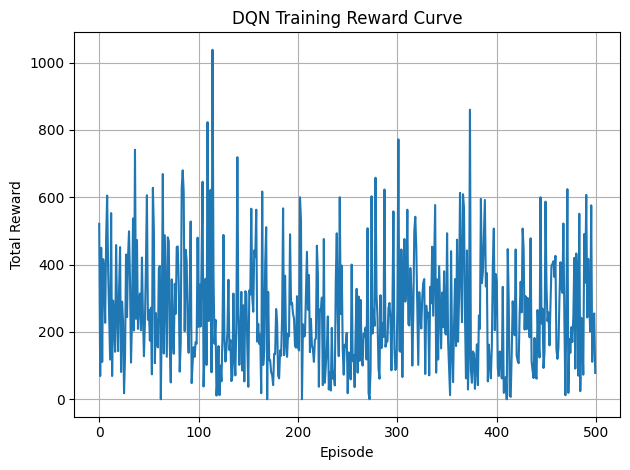

In [ ]:
# 畫出 reward 曲線圖
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Reward Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

## Play with Train model

In [ ]:
def play_with_trained_model():
    env = SpaceShipEnv()
    policy_net = DQN(action_dim)
    policy_net.load_state_dict(torch.load("best_dqn_space_ship.pth", map_location=torch.device('cuda')))
    policy_net.eval()

    state = preprocess(env.reset())
    done = False
    reward = 0

    while not done:
        env.render()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            action = torch.argmax(q_values).item()

        next_state_raw, reward, done, _ = env.step(action)
        state = preprocess(next_state_raw)

    env.close()
    print(f"reward: {reward}")


In [ ]:
def record_episode_as_video(env, video_path="gameplay.mp4"):
    frames = []

    state = env.reset()
    done = False

    while not done:
        env.render()
        action = random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        
        # 把畫面抓下來（RGB）
        surface = pygame.display.get_surface()
        frame = pygame.surfarray.array3d(surface)  # shape: (W, H, 3)
        frame = np.transpose(frame, (1, 0, 2))     # pygame 是 x,y → imageio 是 y,x
        frames.append(frame)


    # 儲存成影片
    imageio.mimsave(video_path, frames, fps=60, quality=9)
    print(f"Saved gameplay video to: {video_path}")


In [ ]:
# env = SpaceShipEnv()
# record_episode_as_video(env, "space_ship_run.mp4")
# env.close()

In [ ]:
# 呼叫測試函數
# play_with_trained_model()